# Iceberg, right ahead!

*Introducing Machine Learning classification using the RMS Titanic passenger manifest.*

This post introduces the exciting topic of Machine Learning. We will use the passenger manifest of the ill-fated RMS Titanic to predict whether a given person would survive the disaster. The passenger manifest includes information about the class, sex, age etc. of each passenger.

In this post, you'll learn how to:
- engineer new features;
- impute missing data;
- one-hot encode categorical features; and
- train and evaluate a model.

By the end, you'll learn how to predict how likely Ms. Dorothy Winifred Gibson was to survive the RMS Titanic disaster:

In [15]:
df = pd.read_csv('data/titanic/gibson.csv', index_col='PassengerId')
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1294,1,"Gibson, Miss. Dorothy Winifred",female,22,0,1,112378,59.4,NaN,C


This [notebook is available on GitHub](https://github.com/ActaMachina/notebooks/blob/master/02-titanic.ipynb) and the [data is hosted on Amazon CloudFront](/data/02-titanic.zip).

## Preamble

In [6]:
from collections import defaultdict
from IPython.display import Image
from matplotlib import lines
from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# pd.set_option('display.max_rows', 5)

## Machine Learning Workflow

Let's start by importing a few Python packages. We'll be needing: (i) `scipy` for its library of statistical functions, (ii) `sklearn`, which provides a comprehensive suite of machine learning models and utility functions; and (iii) `pandas`, which was introduced in the previous post.

In [7]:
from scipy.special import boxcox1p
from scipy.stats import skew, skewnorm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd

## Load Data

Let's load the data in `manifest.csv` into a Pandas DataFrame with `PassengerId` as index:

In [8]:
df = pd.read_csv('data/titanic/manifest.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The DataFrame has 11 columns:

| Feature  | Description |
| -------- | ----------- |
| Survived | Survival |
| Pclass   | Ticket Class |
| Name     | Name |
| Sex      | Sex |
| Age      | Age (Years) |
| SibSp    | Number of Siblings/Spouses Aboard |
| Parch    | Number of Parents/Children Aboard |
| Ticket   | Ticket Number |
| Fare     | Passenger Fare |
| Cabin    | Cabin Number |
| Embarked | Port of Embarkation |



Calling `df.dtypes` reveals the data types for each column, but calling `df.info()` will reveal the number of `null` values as well:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Since we're interested in predicting whether Ms. Dorothy Winifred Gibson survived the RMS Titanic disaster, we add her passenger manifest information to the end of the DataFrame so the features are transformed in the same way:

In [10]:
df = df.append({
    'Pclass': 1,
    'Name': 'Gibson, Miss. Dorothy Winifred',
    'Sex': 'female',
    'Age': 22,
    'SibSp': 0,
    'Parch': 1,
    'Ticket': 112378,
    'Fare': 59.4,
    'Cabin': np.NaN,
    'Embarked': 'C',
}, ignore_index=True)
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
887,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,1.0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,0.0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q
891,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.40,NaN,C


Most Machine Learning models only work with a complete DataFrame of numbers. The model will use all the columns apart from the target column (the features), to try and and predict the target column. In this case, the target column is `Survived` and the other columns make up the features.

Notice that `Age`, `Cabin` and `Embarked` don't have as many entries as the other columns and contain missing values. We will come back to this later.

Now, we want to make sure all the columns are their correct Pandas data type:

| Feature  | Current `dtype` | Correct `dtype` |
| -------- | --------------- | ----------------|
| Survived | `int64`         | `bool`          |
| Pclass   | `int64`         | `category`      |
| Name     | `object`        | `object`        |
| Sex      | `object`        | `category`      |
| Age      | `float64`       | `float64`       |
| SibSp    | `int64`         | `int64`         |
| Parch    | `int64`         | `int64`         |
| Ticket   | `object`        | `object`        |
| Fare     | `float64`       | `float64`       |
| Cabin    | `object`        | `object`        |
| Embarked | `object`        | `category`      |

Converting the mismatched data types:

In [11]:
# convert to bool
df.Survived = df.Survived.astype(bool)

# convert to category
df.Pclass = df.Pclass.astype('category')
df.Sex = df.Sex.astype('category')
df.Embarked = df.Embarked.astype('category')

## Feature Engineering

Instead of jumping straight to training a Machine Learning prediction model, we see whether we can add a few extra columns that may help increase the predictive power of the model.

Let's examine the `Name` column:

In [12]:
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The `Name` column isn't very usable in its current form, but if we can extract the title of each passenger, it can be used as an indicator of socio-economic class. To extract the title, we use regular expressions to isolate the substring between the space and period.

In [13]:
df['Title'] = df.Name.str.extract(r' ([^\s]+)\.')
df[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


We list all the unique titles and their counts:

In [14]:
df.Title.value_counts()

Mr          517
Miss        183
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Sir           1
Don           1
Jonkheer      1
Mme           1
Ms            1
Lady          1
Capt          1
Countess      1
Name: Title, dtype: int64

We can group them uncommon titles together, replacing them with "Rare".

In [15]:
df.Title.replace({
    'Capt': 'Rare',
    'Col': 'Rare',
    'Countess': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Jonkheer': 'Rare',
    'Lady': 'Rare',
    'Major': 'Rare',
    'Master': 'Master',
    'Miss': 'Ms',
    'Mlle': 'Ms',
    'Mme': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Ms': 'Ms',
    'Rev': 'Rare',
    'Sir': 'Rare',
}, inplace=True)

df.Title.value_counts()

Mr        517
Ms        186
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

Since there are only 5 unique titles, we can happily convert the column to the `category` data type.

In [16]:
df.Title = df.Title.astype('category')

We add two more potentially useful features: `FamilySize` and `TravellingAlone`.

In [17]:
df['FamilySize'] = df.SibSp + df.Parch + 1
df['TravellingAlone'] = (df.FamilySize == 1)

## Impute Missing Data

Since Machine Learning algorithms don't work well with `null` or missing values, we either have to fill them in or delete the entire row/column with the missing values. Let's look at the 3 columns that contain missing values, `Age`, `Cabin` and `Embarked`, each in turn:

### Age

In [18]:
df.Age.value_counts(dropna=False).head()

NaN      177
 24.0     30
 22.0     28
 18.0     26
 28.0     25
Name: Age, dtype: int64

Since `NaN`s make up a large proportion of the values in the column, we set the missing values to 0.0 and add another column indicating that the value is missing.

In [19]:
df['AgeMissing'] = df.Age.isna()
df.Age.fillna(0.0, inplace=True)

### Cabin

In [20]:
df.Cabin.value_counts(dropna=False).head()

NaN            688
G6               4
B96 B98          4
C23 C25 C27      4
F2               3
Name: Cabin, dtype: int64

Nearly all the values in the `Cabin` column are `NaN`. It's easiest to just drop the entire column.

In [21]:
df.drop('Cabin', axis=1, inplace=True)

### Embarked

In [22]:
df.Embarked.value_counts(dropna=False).head()

S      644
C      169
Q       77
NaN      2
Name: Embarked, dtype: int64

The ports where people embarked were: Cherbourg (C), Queenstown (Q) and Southampton (S). Since the overwhelming majority of people embarked at Southampton and there are only 2 `NaN`s, we just assume that those 2 people also embarked at Southampton.

In [23]:
df.Embarked.fillna('S', inplace=True)

With the `NaN`s either filled in or removed, the issue with Machine Learning algorithms is that it is unable to process raw strings. Let's look at the columns again:

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 14 columns):
Survived           892 non-null bool
Pclass             892 non-null category
Name               892 non-null object
Sex                892 non-null category
Age                892 non-null float64
SibSp              892 non-null int64
Parch              892 non-null int64
Ticket             892 non-null object
Fare               892 non-null float64
Embarked           892 non-null category
Title              892 non-null category
FamilySize         892 non-null int64
TravellingAlone    892 non-null bool
AgeMissing         892 non-null bool
dtypes: bool(3), category(4), float64(2), int64(3), object(2)
memory usage: 55.4+ KB


Pandas represents strings with the `object` data type. Since the model can only use features that are numbers, we remove those columns:

In [25]:
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

## One-Hot Encoding

Category names are often strings and cannot be processed directly by Machine Learning models. One way to solve this is to map category names to category codes, e.g. `Monday = 1`, `Tuesday = 2`, `Wednesday = 3`, etc. This may work well for categories like days of the week, but not all categories have a natural ordering. Mapping `Apple = 1`, `Banana = 2`, `Cherries = 3` for a fruits category column implies that the relationship between Apples and Bananas is closer than Apples to Cherries, which is untrue.

The solution is one-hot encoding. One-hot encoding splits a categorical column into as many columns as there are categories. Then, in each row, a 1 is placed in the column corresponding to the correct category.

For example, suppose we have a DataFrame of fruit varieties and the type of fruit it corresponds to:

In [26]:
df_fruits = pd.DataFrame([{'variety': 'Bing', 'type': 'Cherries'},
                          {'variety': 'Cavendish', 'type': 'Bananas'},
                          {'variety': 'Granny Smith', 'type': 'Apples'},
                          {'variety': 'Plantain', 'type': 'Bananas'},
                          {'variety': 'Red Delicious', 'type': 'Apples'}])

df_fruits.type = df_fruits.type.astype('category')
df_fruits[['variety', 'type']]

,variety,type
0,Bing,Cherries
1,Cavendish,Bananas
2,Granny Smith,Apples
3,Plantain,Bananas
4,Red Delicious,Apples


When one-hot encoded, the type column (which is already a `category` data type) results in:

In [27]:
pd.get_dummies(df_fruits, columns=['type'])

,variety,type_Apples,type_Bananas,type_Cherries
0,Bing,0,0,1
1,Cavendish,0,1,0
2,Granny Smith,1,0,0
3,Plantain,0,1,0
4,Red Delicious,1,0,0


Calling `pd.get_dummies` with a DataFrame, one-hot encodes all columns with an object or category data type.

In [28]:
df = pd.get_dummies(df)
df.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'TravellingAlone', 'AgeMissing', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rare'],
      dtype='object')

## Fix Skewness for Numerical Features

Machine Learning algorithms work better when the data is as close to symmetric as possible. Data can often have a negative skew or a positive skew: 

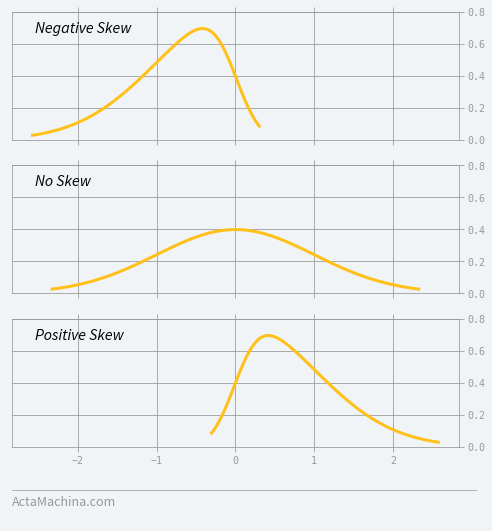

In [29]:
with plt.style.context(('plot.mplstyle')):
    fig, ax = plt.subplots(3, 1, sharex='col', figsize=(8, 8))

    a = -4
    x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 100)
    ax[0].plot(x, skewnorm.pdf(x, a), color='#ffc018', lw=3);
    ax[0].set_title('Negative Skew', family='Source Sans Pro', fontsize=16, fontstyle='italic', loc='left', x=0.05, y=0.45);
    ax[0].set_ylim(0, 0.8);
    ax[0].yaxis.tick_right()


    a = 0
    x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 100)
    ax[1].plot(x, skewnorm.pdf(x, a), color='#ffc018', lw=3);
    ax[1].set_title('No Skew', family='Source Sans Pro', fontsize=16, fontstyle='italic', loc='left', x=0.05, y=0.45);
    ax[1].set_ylim(0, 0.8);
    ax[1].yaxis.tick_right()

    a = 4
    x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 100)
    ax[2].plot(x, skewnorm.pdf(x, a), color='#ffc018', lw=3);
    ax[2].set_title('Positive Skew', family='Source Sans Pro', fontsize=16, fontstyle='italic', loc='left', x=0.05, y=0.45);
    ax[2].set_ylim(0, 0.8);
    ax[2].yaxis.tick_right()
    
    # footer
    ax[2].add_line(lines.Line2D([0.125, 0.93], [0.05, 0.05], linewidth=1, color='0.7', clip_on=False, transform=fig.transFigure))
    plt.text(0.125, 0.04, 'ActaMachina.com' + '\n', color='0.6', family='Source Sans Pro', fontsize=14, horizontalalignment='left', verticalalignment='top', transform=plt.gcf().transFigure)

Box-Cox transform will help reshape each skewed column so the Machine Learning algorithm can converge faster on a result:

In [30]:
lambda_ = 0.15

skewness = pd.DataFrame({'Skew': df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)})
skewed_columns = skewness[abs(skewness) > 0.75].dropna().index

print(f"There are {skewed_columns.shape[0]} skewed features to Box Cox transform: {', '.join(sorted(skewed_columns))}.")

for column in skewed_columns:
    df[column] = boxcox1p(df[column], lambda_)

There are 14 skewed features to Box Cox transform: AgeMissing, Embarked_C, Embarked_Q, Embarked_S, FamilySize, Fare, Parch, Pclass_1, Pclass_2, SibSp, Title_Master, Title_Mrs, Title_Ms, Title_Rare.


## Model

We now have everything we need in order to train a RMS Titanic survivor classifier model. In Machine Learning, it is customary to separate the features (X) from the target label that we're trying to predict (y):

In [31]:
X = df[:-1].drop('Survived', axis=1)
y = df[:-1].Survived.values.ravel()

Notice that we have left out the final row which contains Ms. Dorothy Winifred Gibson's manifest. It is important that our model does not include this as it is precisely the piece of information that we are trying to predict. It would be meaningless to create a model that predicts something it already knows in advance.

To assess the performance of the model, we further divide X and y into a training set and a test set. For the same reason that we leave out Ms. Dorothy Winifred Gibson's manifest, we fit the model on the training set (`X_train`, `y_train`) and assess it on the test set (`y_test`, `y_train`), which is unseen data.

A common ratio for smaller datasets is a 3:1 ratio of training data to test data. For bigger datasets, a smaller proportion of test data is often used. Since this is a smaller dataset, out of 891 total rows, 668 rows are assigned to the training set and the remaining 223 rows form the test set.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

To know why we need to separate data into training and test sets, we need to understand that the Machine Learning model is trying to fit the training data as closely as possible.

- If the model doesn't fit the training data closely enough (underfitting), the model is unlikely to be useful at all. So a model that underfits will have low accuracy on both the train and test sets. To fix this, we need to improve the model by increasing model complexity, e.g. through engineering better features, improved imputing of missing values, tuning model parameters and even switching models completely.

- If the model fits the training data too closely (overfitting), the model is unlikely to be useful on data it hasn't seen before, e.g. the test set. So a model that overfits will have much lower accuracy on the test set than the training set. To fix this, we can: (i) train with more data, (ii) have the model only use the more important features and (iii) favour simpler models over more complex models.

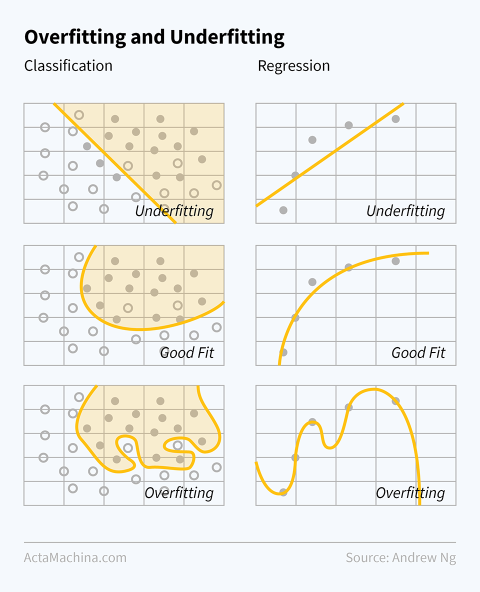

In [33]:
Image('figures/02-overfitting-underfitting.png')

The type of classifier we will use is the Random Forest Classifier. It creates a decision tree based on the features in `X` (details below). We fit the model with the training set and then we score it with the test set:

In [58]:
model = RandomForestClassifier(n_estimators=10, bootstrap=False)
model.fit(X_train, y_train)
print(f'Train Accuracy: {model.score(X_train, y_train)*100:.3f}%')

Train Accuracy: 98.952%


In [59]:
print(f'Test Accuracy: {model.score(X_test, y_test)*100:.3f}%')

Test Accuracy: 80.717%


The score is the proportion of correctly labelled predictions. We see that we got 80.717% of the labels correct. Not bad! Looking at the discrepancy between the train and test accuracies, it does seem that our model overfit the training data.

To get an idea of how the random forest classifier works, here are the first 3 layers of our model:

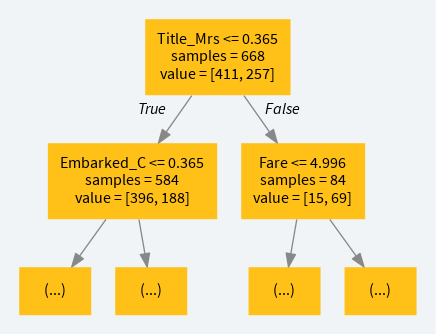

In [36]:
import pydotplus

dot_data = export_graphviz(model.estimators_[0],
                           feature_names=X.columns,
                           out_file=None,
                           filled=True,
                           rounded=False,
                           impurity=False,
                           max_depth=1)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_bgcolor('#f0f4f7')
graph.set_fontname('Source Sans Pro')
graph.set_pad(0.2)

nodes = graph.get_node_list()
for node in nodes:
    node.set_fillcolor('#ffc018')
    node.set_penwidth(0)
    node.set_fontname('Source Sans Pro')
    node.set_fontsize(12)
    node.set_margin(0.125)
    
edges = graph.get_edge_list()
for edge in edges:
    edge.set_color('#888888')
    edge.set_fontname('Source Sans Pro Italic')
    edge.set_fontsize(12)
    
graph.write_png('figures/03-decision-tree.png')
Image('figures/03-decision-tree.png')

A trained random forest classifer produces a decision tree, where: (i) each node contains a test on a feature; (ii) each branch is an outcome of the test; and (iii) each leaf is a class.

Looking at the text inside the top, root node:
- `PClass_1 <= 0.365` is the test condition used to split up the samples into the child nodes: true on the left and false on the right;
- `samples = 668`  is the number of samples at the current step (since this is the root node, it contains all 668 samples in `X_train` that were used to train the model); and
- `value = [417, 251]` is the [False, True] split of the samples.

A random forest is trained by combining multiple decision trees using majority voting, with each decision tree generated using a random subset of features.

Now, let's use the model to predict whether Ms. Dorothy Winifred Gibson survived:

In [115]:
model.predict(df.drop('Survived', axis=1).tail(1))

array([ True])

Our model predict that she survived! In fact, not only did she survive, but Ms. Dorothy Winifred Gibson was a silent film actress who starred in the first motion picture based on the RMS Titantic disaster. 

## Summary and Next Steps

In this post, you've learnt how to:
- engineer new features;
- impute missing data;
- one-hot encode categorical features; and
- train and evaluate a model.

You can now train your own model! If you want, you can try it on the [Iris flower data set](https://archive.ics.uci.edu/ml/datasets/iris). The dataset contains 50 samples  from each of 3 species of Iris, with 4 features recorded in each sample: the length and with of the sepals and petals.

The type of Machine Learning algorithm you've used is called Supervised Learning since you are given a set of correctly mapped inputs (the passenger manifest) and outputs (whether they survived or not). More specifically, this is classification because we classify them into classes (survivors and non-survivors). The other type of supervised learning is regression (predicting a quantity rather than a class), and will be covered in the next post where we look at predicting house prices in Ames, Iowa.

## Acknowledgements

This post has been inspired by posts from:

- [Kaggle Getting Started Prediction Competition](https://www.kaggle.com/c/titanic)
- [Introduction to Ensembling/Stacking in Python by Arthur Tok](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)
- [Titanic Data Science Solutions by Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions)

## Notes

There are three broad types of Machine Learning:
- Supervised Learning is where you are given a set of correctly mapped inputs (the passenger manifest) and outputs (whether they survived or not);
- Unsupervised Learning is when you are only given inputs and tasked to find interesting attributes of the dataset, such as clusters or outliers; and
- Reinforcement Learning is where an agent interacts with an environment and changes its action based on rewards.